In [1]:
# Spark dependencies
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import lit, udf
from pyspark.sql.types import ArrayType
from pyspark.sql.types import FloatType
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

# Miscellaneous dependencies
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
password = os.getenv('MONGODB_ROOT_PASSWORD')
mongoInputUri = 'mongodb://root:{}@my-mongodb:27017'.format(password)
mongoOutputUri = 'mongodb://root:{}@my-mongodb:27017'.format(password)

In [3]:
spark = SparkSession \
    .builder \
    .appName("PySparkPopulationAlgorithm") \
    .config("spark.mongodb.input.uri", mongoInputUri) \
    .config("spark.mongodb.output.uri", mongoOutputUri) \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.4.1') \
    .getOrCreate()
sc = spark.sparkContext

In [4]:
df = spark \
    .read \
    .format("com.mongodb.spark.sql.DefaultSource") \
    .option("database", "geotest-db") \
    .option("collection", "2020_pop_geojson") \
    .load()

In [5]:
# Put mongo data in dataframe
dfCoordinatesRasterValues = df.select("geometry.coordinates", "properties.raster_val")

# Transform the dataframe into three columns: x,y,z
take_first_udf = udf(lambda y: y[0], FloatType())
take_second_udf = udf(lambda y: y[1], FloatType())
dfxyz = dfCoordinatesRasterValues.select( \
        take_first_udf('coordinates').alias('x'), \
        take_second_udf('coordinates').alias('y'), \
        dfCoordinatesRasterValues.raster_val.cast(FloatType()).alias('z'))

In [6]:
# Prepare dataframe for K means clustering
FEATURES_COL = ['x', 'y', 'z']
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(dfxyz).select('features')

In [65]:
# K means clustering
k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()
dfTagsPredictions = model.transform(df_kmeans)

In [83]:
# find the largest value in the centers array
centerSorted = sorted(centers, key=lambda x: x[2], reverse=True)
z = np.array([row[2] for row in centers])
n = 1
if n<k:
    indices = np.zeros(n)
    for i in range(0,n):
        indices[i] = np.where(centerSorted[i][2]==z)[0][0]
else: 
    print('n must be smaller than k, the number of clusters')

In [85]:
dfClusterPointsRaw = dfTagsPredictions.filter(dfTagsPredictions.prediction.isin(*indices) == True)

In [86]:
def ith_(v, i):
    try:
        return float(v[i])
    except ValueError:
        return None

ith = udf(ith_, FloatType())

dfClusterxyz = dfClusterPointsRaw.select(ith("features", lit(0)).alias('x'), ith("features", lit(1)).alias('y'), ith("features", lit(2)).alias('z'))

In [87]:
xClusterRaw = dfClusterxyz.select("x").collect()
xCluster = [float(row.x) for row in xClusterRaw]
yClusterRaw = dfClusterxyz.select("y").collect()
yCluster = [float(row.y) for row in yClusterRaw]
zClusterRaw = dfClusterxyz.select("z").collect()
zCluster = [float(row.z) for row in zClusterRaw]

In [88]:
xRaw = dfxyz.select("x").collect()
x = [float(row.x) for row in xRaw]
yRaw = dfxyz.select("y").collect()
y = [float(row.y) for row in yRaw]
zRaw = dfxyz.select("z").collect()
z = [float(row.z) for row in zRaw]
z = np.array(np.log10(np.array(z) + 1))
z = (z - np.min(z))/(np.max(z) - np.min(z))

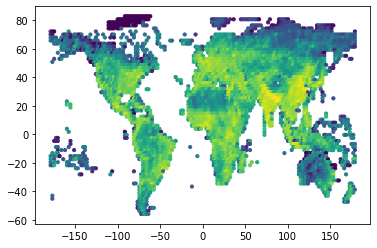

In [89]:
plt.scatter(x,y,c=z, s=10, cmap='viridis')
plt.show()

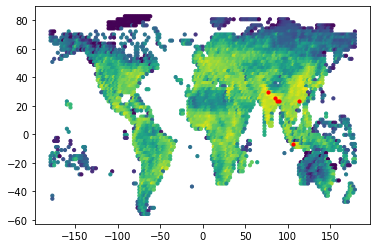

In [94]:
plt.scatter(x,y,c=z, s=10, cmap='viridis')
plt.scatter(xCluster,yCluster, s=10, color='red')
plt.show()

In [ ]:
# Compute the average of the xyz
xMean = dfxyz.agg({"x": "mean"}).collect()[0][0]
yMean = dfxyz.agg({"y": "mean"}).collect()[0][0]
zMean = dfxyz.agg({"z": "max"}).collect()[0][0]
print("[x_mean y_mean z_max]: " + str(np.array([xMean,yMean,zMean])))

In [ ]:
maxCoord = np.array(dfCoordinatesRasterValues.agg({"xy": "max"}).collect()[0][0]).mean(axis=0)
minCoord = np.array(dfCoordinatesRasterValues.agg({"xy": "min"}).collect()[0][0]).mean(axis=0)
np.array([maxCoord,minCoord]).mean(axis=0)

In [ ]:
# TEST 2

# Local import geojson
json_path = './some_windows.json'
dfFeatureCollection = spark.read.json(json_path)
# dfFeatureCollection.printSchema()

In [ ]:
# TEST 2

# kleine json zoals het vanuit mongodb komt
jsonStrings = ["""{"type": "Feature", 
    "properties": {"raster_val": 14.925607681274414}, 
    "geometry": {
        "type": "Polygon", 
        "coordinates": [
            [[61.06541643740002, 34.93291672831001], 
            [61.06541643740002, 34.92458339501001], 
            [61.07374977070002, 34.92458339501001], 
            [61.07374977070002, 34.93291672831001], 
            [61.06541643740002, 34.93291672831001]]
        ]
    }
}"""]

# Maak een dataframe van de json
featureRDD = sc.parallelize(jsonStrings)
feature = spark.read.json(featureRDD)

# Show het schema van de json
feature.printSchema()

# Extract waardes van json
rasterValue = feature.select("properties.raster_val").collect()[0].raster_val
coordinates = feature.select("geometry.coordinates").collect()[0].coordinates

print("rasterValue: " + str(rasterValue))
print("[longitude, lattitude]: " + str( np.array(coordinates[0])[0:4].mean(axis=0)))